- sensibilidade alta com as prioris, pode ser fácil encontrar o shape, mas precisará ficar ajustando a priori para acertar a escala;
- GP marginais - find_map
- GP marginais aproximadas:
    - sample
- HSGP - Hilbert Space Gaussian Process

PCT_change
Rt = (Xt-1 - Xt) / Xt
Rt =(52-50)/50 = 0.04

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


# Importação das bibliotecas necessárias para o projeto

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import seaborn as sns

## Carregando base de dados

In [3]:
# Carregamento dos dados a partir de um arquivo CSV localizado no Google Drive.
original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PI5/staging/porto_ts.csv")

In [4]:
original

,ano,mes,porto,graos,outras,sugar
0,2005,1,5027941,412400,1780376,581383
1,2005,2,5316605,707274,1821686,878016
2,2005,3,5899912,1221079,1917759,610140
3,2005,4,5850639,1301598,1976311,764285
4,2005,5,6826372,1575474,2122232,1007705
...,...,...,...,...,...,...
211,2022,8,14626790,4122517,3188229,2455597
212,2022,9,13628567,3743920,3258989,2079487
213,2022,10,14435751,4185655,3198681,2249483
214,2022,11,12194409,3459541,2558110,2199680


### Alguns ajustes para o projeto atual

In [5]:
# remoção de colunas desnecessárias
original.drop(['graos','outras','sugar'], axis=1, inplace=True)

In [6]:
original

,ano,mes,porto
0,2005,1,5027941
1,2005,2,5316605
2,2005,3,5899912
3,2005,4,5850639
4,2005,5,6826372
...,...,...,...
211,2022,8,14626790
212,2022,9,13628567
213,2022,10,14435751
214,2022,11,12194409


In [7]:
# Conversão das colunas 'ano' e 'mes' para um índice datetime.
original['data'] = pd.to_datetime(original['ano'].astype(str) + '-' + original['mes'].astype(str), format='%Y-%m')
original['lastDay'] = original['data'] + pd.offsets.MonthBegin(0)   # set a data no início do mês
#original['lastDay'] = original['data'] + pd.offsets.MonthEnd(0)    # set a data no final do mês

original['data'] = original['lastDay'].dt.strftime("%Y-%m-%d")
original.drop(['lastDay'], axis=1, inplace=True)

print(original)

      ano  mes     porto        data
0    2005    1   5027941  2005-01-01
1    2005    2   5316605  2005-02-01
2    2005    3   5899912  2005-03-01
3    2005    4   5850639  2005-04-01
4    2005    5   6826372  2005-05-01
..    ...  ...       ...         ...
211  2022    8  14626790  2022-08-01
212  2022    9  13628567  2022-09-01
213  2022   10  14435751  2022-10-01
214  2022   11  12194409  2022-11-01
215  2022   12  12096270  2022-12-01

[216 rows x 4 columns]


In [8]:
data_orig = original.data[:len(original)]    # verificar
data_orig

0      2005-01-01
1      2005-02-01
2      2005-03-01
3      2005-04-01
4      2005-05-01
          ...    
211    2022-08-01
212    2022-09-01
213    2022-10-01
214    2022-11-01
215    2022-12-01
Name: data, Length: 216, dtype: object

## Normalização da data


In [9]:
min_month = original.index.min()
max_month = original.index.max()
print(min_month, max_month)
data_std = (original.index - min_month)/(max_month-min_month)
original['data_std'] = data_std

0 215


In [10]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
print(maximo_mov, minimo_mov)
mov_std = (original.porto - minimo_mov) / (maximo_mov - minimo_mov)
original['porto_std'] = mov_std
original

15165869 4588410


,ano,mes,porto,data,data_std,porto_std
0,2005,1,5027941,2005-01-01,0.000000,0.041554
1,2005,2,5316605,2005-02-01,0.004651,0.068844
2,2005,3,5899912,2005-03-01,0.009302,0.123990
3,2005,4,5850639,2005-04-01,0.013953,0.119332
4,2005,5,6826372,2005-05-01,0.018605,0.211578
...,...,...,...,...,...,...
211,2022,8,14626790,2022-08-01,0.981395,0.949035
212,2022,9,13628567,2022-09-01,0.986047,0.854662
213,2022,10,14435751,2022-10-01,0.990698,0.930974
214,2022,11,12194409,2022-11-01,0.995349,0.719076


## Gerando dataframe apenas com dados necessários

In [11]:
original_std = original[['data_std', 'porto_std']]
original_std.index = original_std.data_std
original_std.drop(['data_std'], axis=1,inplace=True)
original_std

<ipython-input-11-66111c678ec3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_std.drop(['data_std'], axis=1,inplace=True)


,porto_std
data_std,
0.000000,0.041554
0.004651,0.068844
0.009302,0.123990
0.013953,0.119332
0.018605,0.211578
...,...
0.981395,0.949035
0.986047,0.854662
0.990698,0.930974


# Divisão dos dados em Treino / Teste  aproximadamente 80%

In [12]:
# Definindo os dados para treinamento
x = original_std.index.values.T
y = original_std.porto_std.values.T

# percentual para treinamento
perc = 0.8                          # o mais próximo possível
periodo = int(len(x) * perc // 12)       # período em anos
n = periodo * 12
treino_split = n-1       # anos para treino /total

# Exibindo a divisão de dados para treino
print(f'{n} meses\n{n/12} anos\n{treino_split/216*100:.2f} %')

168 meses
14.0 anos
77.31 %


In [13]:
# Final do período de treino
original.iloc[treino_split]

ano                2018
mes                  12
porto          10863015
data         2018-12-01
data_std       0.776744
porto_std      0.593205
Name: 167, dtype: object

In [14]:
# separação treino/teste
x_treino = x[ :treino_split+1]
x_teste  = x[treino_split+1: ]

y_treino = y[:treino_split+1]
y_teste  = y[treino_split+1:]

In [15]:
print(len(x_treino), len(y_treino), len(x_teste), len(y_teste))

168 168 48 48


In [16]:
#x_treino
#x_teste
#y_treino
y_teste

array([0.41544099, 0.51814968, 0.64249835, 0.57047983, 0.6055651 ,
       0.66068353, 0.77338206, 0.70899599, 0.65999821, 0.77529149,
       0.60890163, 0.53158296, 0.35217721, 0.57364165, 0.77605103,
       0.8415212 , 0.80086976, 0.73515047, 0.84843212, 0.86455537,
       0.71691055, 0.74599126, 0.71206553, 0.68780479, 0.43526049,
       0.59929223, 1.        , 0.86706268, 0.89786309, 0.82046662,
       0.76002526, 0.7069229 , 0.68669252, 0.58038448, 0.62902461,
       0.71229858, 0.57778763, 0.78576679, 0.99933207, 0.87020758,
       0.91222703, 0.90346642, 0.94496306, 0.94903511, 0.85466245,
       0.93097416, 0.7190762 , 0.70979807])

[Text(0.5, 1.0, 'Separação Treino / Teste'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

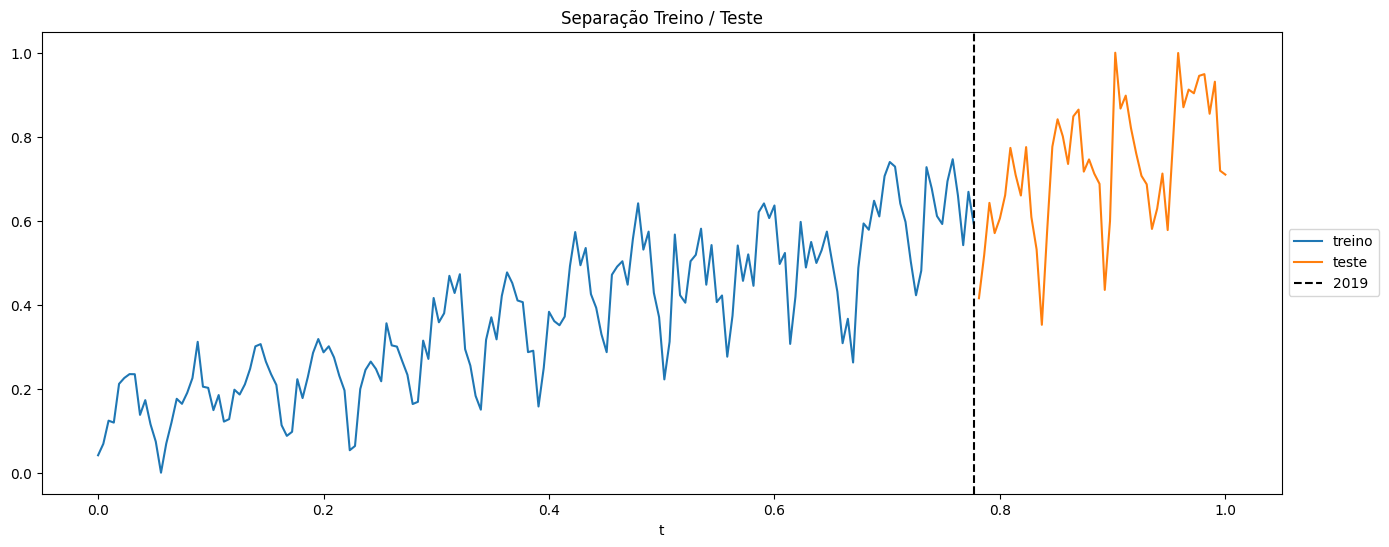

In [17]:
# Plotagem do gráfico da série temporal já dividida em treino/teste
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x=x_treino, y=y_treino, label='treino', ax=ax)
sns.lineplot(x=x_teste, y=y_teste, label='teste', ax=ax)
ax.axvline(x=x_treino[-1], linestyle='--', label='2019', color='k')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Separação Treino / Teste', xlabel='t', ylabel='')

# Modelo GP

In [34]:
with pm.Model() as ts_model:
    l = pm.HalfNormal('l', (3/2)**(1/250)-1)

    #M = pm.gp.mean.Zero() # linear
    M = pm.gp.mean.Linear(0.5,0.5)
    K = pm.gp.cov.Matern32(1, l)

    err = pm.HalfNormal('err', 0.1)
    xuu = pm.gp.util.kmeans_inducing_points(40, x_treino.reshape(-1,1))

    gp_comp = pm.gp.MarginalApprox(mean_func=M, cov_func=K)
    gp_comp.marginal_likelihood('target', X=x_treino.reshape(-1,1), y=y_treino, Xu=xuu, noise=err)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [35]:
(3/2)**(1/250)-1

0.0016231763593843596

In [36]:
with ts_model:
  trace = pm.sample()

In [37]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l,0.021,0.001,0.018,0.023,0.000,0.000,814.0,957.0,1.0
err,0.337,0.028,0.283,0.387,0.001,0.001,804.0,935.0,1.0


array([[<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>],
       [<Axes: title={'center': 'err'}>, <Axes: title={'center': 'err'}>]],
      dtype=object)

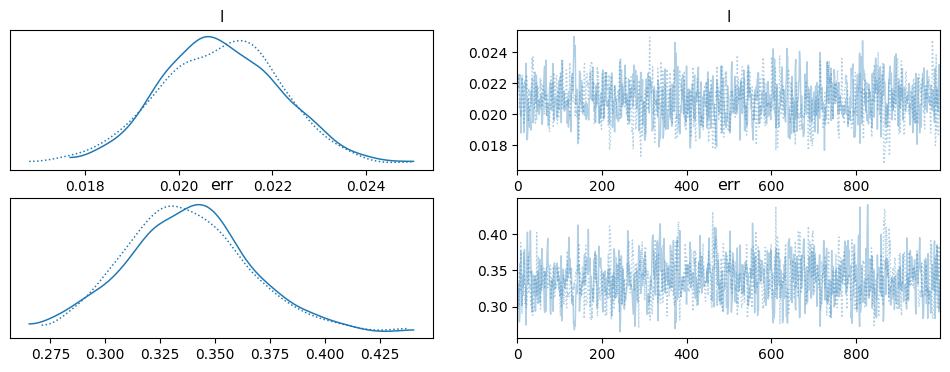

In [38]:
az.plot_trace(trace)

In [39]:
with ts_model:
    x_test_con = gp_comp.conditional('x_test_con', x_teste.reshape(-1,1))
    pred = pm.sample_posterior_predictive(trace, var_names=["x_test_con"])

<ipython-input-39-85449b7e3bca>:3: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pred = pm.sample_posterior_predictive(trace, var_names=["x_test_con"])


<Axes: >

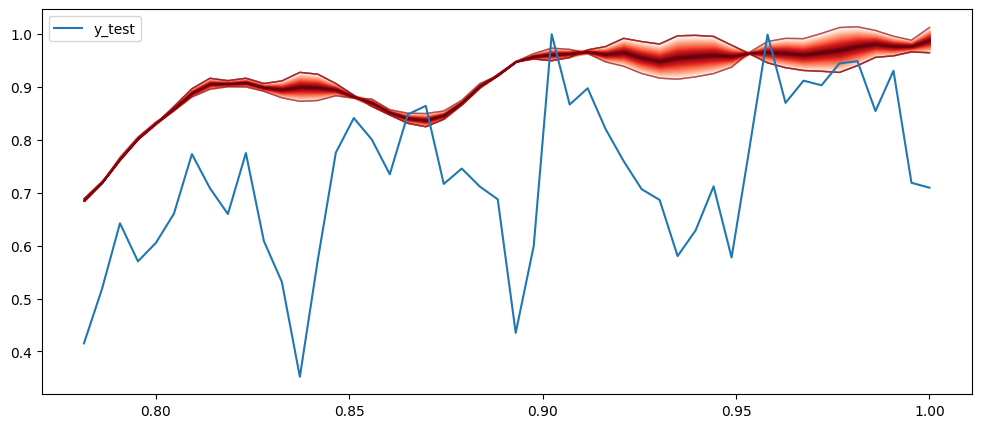

In [40]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, pred.posterior_predictive["x_test_con"].values.mean(axis=1), x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_test', ax=ax)

In [42]:
# modelo de volatilidade variável / retorno constante
daily_ret_annual = 2**(1/250)-1

with pm.Model() as ts_model_l:
    ret = pm.Normal("ret",0,daily_ret_annual)
    std = pm.Normal("std", pm.math.log(daily_ret_annual), 0.05)

    l = pm.Gamma('l', 1, 2)
    s = pm.Exponential('s', 100)

    #M = pm.gp.mean.Zero()
    M = pm.gp.mean.Linear(0.5,1)

    w_err = pm.HalfNormal("w",1)
    K = s * pm.gp.cov.Matern32(1, l)

    gp_comp = pm.gp.HSGP(mean_func=M, cov_func=K, m=[400], c=4)

    delta_std = gp_comp.prior("delta", X=x_treino.reshape(-1,1))
    dd = pm.Deterministic("dd",delta_std)
    d = pm.Deterministic("d",pm.math.exp(std+delta_std))

    likelihood = pm.Normal("likelihood", ret, d, observed=y_treino)

In [43]:
ts_model_l.dd.eval()

array([0.96525456, 0.96468432, 0.96467191, 0.96476247, 0.96426612,
       0.96286815, 0.96184661, 0.96267523, 0.96455622, 0.96551032,
       0.965413  , 0.96581132, 0.96720003, 0.96866435, 0.96994832,
       0.97140001, 0.97200153, 0.97040576, 0.96768323, 0.96571773,
       0.9637662 , 0.96020165, 0.9558813 , 0.95232023, 0.949151  ,
       0.94604882, 0.94389918, 0.94275291, 0.94202557, 0.94229241,
       0.94398601, 0.94645255, 0.94991041, 0.95468919, 0.9586625 ,
       0.96005494, 0.96085218, 0.96292035, 0.9648212 , 0.96649625,
       0.97137593, 0.98050004, 0.99062184, 0.99992355, 1.00970308,
       1.02029119, 1.0306646 , 1.04110207, 1.05204459, 1.06199948,
       1.06932457, 1.07425571, 1.07781635, 1.08039087, 1.08187473,
       1.08221874, 1.08176313, 1.08121472, 1.08117518, 1.08187893,
       1.08308079, 1.08399603, 1.08441267, 1.08562019, 1.08833375,
       1.09079462, 1.09156665, 1.09220813, 1.09438862, 1.09732773,
       1.10039526, 1.10444389, 1.10915643, 1.11313468, 1.11667

In [44]:
with ts_model_l:
  trace_l = pm.find_MAP()

In [45]:
trace_l

{'ret': array(0.00426518),
 'std': array(-5.8473963),
 'l_log__': array(-0.20766298),
 's_log__': array(-1.26375623),
 'w_log__': array(-3.12012764),
 'delta_hsgp_coeffs_': array([ 7.07508496e+00, -1.47824601e+00, -1.70755102e+00,  9.27520635e-01,
        -2.91850655e-02, -4.06686427e-01,  3.98089253e-01,  1.00200659e-01,
        -3.34198310e-01,  4.00646768e-02,  1.54161130e-01, -6.99206755e-02,
         1.06056328e-02,  4.05159173e-02, -1.08299754e-01,  6.03961224e-03,
         1.32633239e-01, -4.13869016e-02, -1.03394289e-01,  5.29382168e-02,
         5.04522208e-02, -4.18878611e-02, -9.06990634e-04,  1.80297845e-02,
        -2.88627712e-02,  6.54690981e-03,  3.53677653e-02, -2.26631075e-02,
        -2.51986926e-02,  2.66983624e-02,  9.42975774e-03, -2.04265425e-02,
         2.09851715e-03,  8.85937387e-03, -4.47840804e-03,  2.53736610e-03,
        -1.51674494e-03, -9.99849351e-03,  1.12368442e-02,  1.23130330e-02,
        -1.91871010e-02, -1.04211210e-02,  2.17376189e-02,  6.312024

In [46]:
with ts_model_l:
    x_test_con_l = gp_comp.conditional('x_test_con', x_teste.reshape(-1,1))
    pred_l = pm.sample_posterior_predictive([trace_l], var_names=["x_test_con"])

In [47]:
preds = pred_l.posterior_predictive["x_test_con"].values
preds[0][0]

array([5.11898682, 5.11276655, 5.10630609, 5.09961063, 5.0926853 ,
       5.08553516, 5.07816517, 5.07058021, 5.0627851 , 5.05478457,
       5.04658328, 5.03818582, 5.02959669, 5.02082033, 5.01186111,
       5.00272333, 4.9934112 , 4.98392888, 4.97428047, 4.96446999,
       4.95450138, 4.94437854, 4.93410531, 4.92368543, 4.91312261,
       4.90242049, 4.89158264, 4.88061259, 4.86951378, 4.85828963,
       4.84694347, 4.83547858, 4.8238982 , 4.81220549, 4.80040358,
       4.78849553, 4.77648436, 4.76437301, 4.75216441, 4.7398614 ,
       4.72746679, 4.71498334, 4.70241376, 4.68976071, 4.67702679,
       4.66421457, 4.65132658, 4.63836528])

<Axes: >

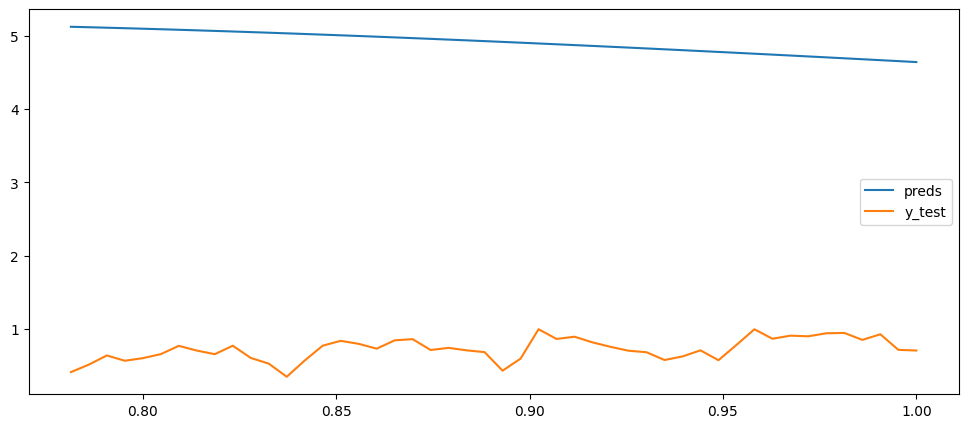

In [48]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

sns.lineplot(x=x_teste.flatten(),y=preds[0][0], label='preds',ax=ax)

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_test', ax=ax)

terceiro modelo

In [50]:
with pm.Model() as model:
    # Tendencia de curto prazo
    η_med = pm.HalfCauchy("η_med",0.5)
    ℓ_med = pm.HalfNormal("ℓ_med", 1)
    α = pm.HalfNormal("α", 1)
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # Tendencia de longo prazo
    η_trend = pm.HalfCauchy("η_trend", 1)
    ℓ_trend = pm.HalfNormal("ℓ_trend", 4)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # Ruidos
    η_noise = pm.HalfNormal("η_noise", 0.5)
    ℓ_noise = pm.HalfNormal("ℓ_noise", 1)

    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise)
    gp_noise = pm.gp.Marginal(cov_func=cov_noise)

    # Soma dos GP
    gp = gp_medium + gp_trend + gp_noise

    σ_err = pm.HalfNormal("σ_noise", sigma=0.3)
    cov_err = pm.gp.cov.WhiteNoise(σ_err)

    y = gp.marginal_likelihood("y", X=x_treino.reshape(-1,1), y=y_treino,sigma=cov_err)


In [51]:
with model:
  trace_c = pm.find_MAP()

In [52]:
with model:
    x_test_con_l = gp.conditional('x_test', x_teste.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive([trace_c], var_names=["x_test"])

In [53]:
pred_m.posterior_predictive["x_test"].values[0][0]

array([0.63304082, 0.63527345, 0.63866901, 0.64019384, 0.64423739,
       0.64518389, 0.64864852, 0.65250625, 0.65500292, 0.65913993,
       0.66117397, 0.66321957, 0.66721859, 0.66837112, 0.67297904,
       0.67287815, 0.67739436, 0.67916801, 0.68400796, 0.68476925,
       0.68920196, 0.68965579, 0.6911845 , 0.69464759, 0.69802878,
       0.69954734, 0.70414219, 0.7051844 , 0.7062442 , 0.71005217,
       0.71032052, 0.71283901, 0.71892183, 0.71991317, 0.72137474,
       0.724635  , 0.72704023, 0.7288493 , 0.73243046, 0.73637655,
       0.73450185, 0.73657456, 0.74025053, 0.74298175, 0.7433589 ,
       0.74591174, 0.75071983, 0.75067036])

<Axes: >

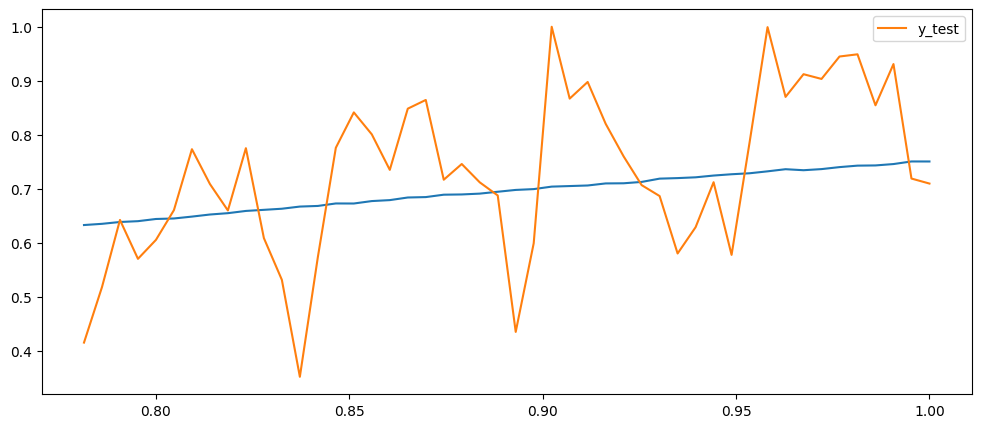

In [55]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

sns.lineplot(ax=ax, x=x_teste.flatten(),y=pred_m.posterior_predictive["x_test"].values[0][0])

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_test', ax=ax)